In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
import json
import os
from tqdm import tqdm

# To disable the huggingface/tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --- Stage 1: Data Preparation ---
class DataPreparer:
    """
    Handles loading, cleaning, and splitting the dataset.
    """
    def __init__(self, file_path, random_seed=42):
        self.file_path = file_path
        self.random_seed = random_seed

    def load_and_prepare(self):
        """Loads and prepares the dataset from the CSV file."""
        print("--- Starting Stage 1: Data Preparation ---")
        self.df = pd.read_csv(f"{self.file_path}.csv")
        self.df = self.df.rename(columns={"code": "utterance", "theme": "label"})
        self.df["utterance"] = self.df["utterance"].astype(str).apply(lambda x: re.sub(r"^\[.*?\]\s*", "", x).strip())
        self.df.dropna(subset=['label', 'utterance'], inplace=True)

        theme_map = {
            'communication through tech': 'Communicating through technology',
            'issues in communication due to technology': 'Communicating through technology',
        }
        self.df['label'] = self.df['label'].replace(theme_map)
        print("Theme optimization complete with new mapping.")

        self.df["label"] = pd.Categorical(self.df["label"])
        self.themes = list(self.df['label'].cat.categories)
        self.df["label"] = self.df["label"].cat.codes

        train_val_df, test_df = train_test_split(
            self.df, test_size=0.15, random_state=self.random_seed, stratify=self.df["label"]
        )
        train_df, dev_df = train_test_split(
            train_val_df, test_size=0.15, random_state=self.random_seed, stratify=train_val_df["label"]
        )

        self.dataset = DatasetDict({
            "train": Dataset.from_pandas(train_df),
            "validation": Dataset.from_pandas(dev_df),
            "test": Dataset.from_pandas(test_df),
        })

        class_label_feature = ClassLabel(names=self.themes)
        self.dataset = self.dataset.cast_column("label", class_label_feature)

        print("Data preparation complete.")
        print(f"Final themes after re-mapping: {self.themes}")
        return self.dataset, self.themes

# --- Stage 2: Prompt-Only Baseline ---
class PromptOnlyBaseline:
    """
    Evaluates zero-shot, four-shot, and chain-of-thought prompting baselines.
    """
    def __init__(self, model_name, themes):
        self.model_name = model_name
        self.themes = themes
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def _get_prediction(self, prompt):
        """Generates a response and parses the theme."""
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=256, truncation=True)
        outputs = self.model.generate(**inputs, max_new_tokens=20, pad_token_id=self.tokenizer.eos_token_id)
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        for i, theme in enumerate(self.themes):
            if theme.lower() in generated_text.lower():
                return i
        return -1

    def evaluate(self, test_dataset, strategy="zero_shot"):
        print(f"\n--- Evaluating Prompt-Only Baseline ({strategy}) ---")
        predictions, true_labels = [], []
        
        four_shot_examples = None
        if strategy == "four_shot":
            four_shot_examples = self.dataset['train'].shuffle(seed=42).select(range(4))

        for item in tqdm(test_dataset, desc=f"Running {strategy} evaluation"):
            utterance = item['utterance']
            true_label = item['label']

            if strategy == "zero_shot":
                prompt = f"Classify the following utterance into one of these themes: {', '.join(self.themes)}. Utterance: '{utterance}'\nTheme:"
            elif strategy == "four_shot":
                 example_str = "\n".join([f"Utterance: '{ex['utterance']}'\nTheme: {self.themes[ex['label']]}" for ex in four_shot_examples])
                 prompt = f"{example_str}\n\nUtterance: '{utterance}'\nTheme:"
            elif strategy == "chain_of_thought":
                prompt = f"Let's think step by step. The themes are: {', '.join(self.themes)}. The utterance is: '{utterance}'. Analyze the utterance and determine the most fitting theme.\nReasoning: The utterance is about... Therefore, the best theme is "

            predicted_label = self._get_prediction(prompt)
            predictions.append(predicted_label)
            true_labels.append(true_label)
            
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average="macro", zero_division=0)

        print(f"Results for {strategy}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Macro-F1 Score: {f1:.4f}")
        return {"accuracy": accuracy, "f1_macro": f1}

# --- Stage 3: Fine-Tuning (PEFT) ---
def compute_metrics(eval_pred):
    """Computes accuracy and F1 score for the Trainer."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    return {"accuracy": accuracy, "f1_macro": f1}

class LoRATrainer:
    """
    Handles the fine-tuning of the model using LoRA.
    """
    def __init__(self, model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0"):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def train(self, tokenized_dataset):
        """Trains the model."""
        print("\n--- Starting Stage 3: PEFT (LoRA) ---")
        num_labels = tokenized_dataset["train"].features["label"].num_classes

        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=num_labels)
        model.config.pad_token_id = model.config.eos_token_id
        model = prepare_model_for_kbit_training(model)

        lora_config = LoraConfig(
            r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"],
            lora_dropout=0.05, bias="none", task_type="SEQ_CLS",
        )
        model = get_peft_model(model, lora_config)

        training_args = TrainingArguments(
            output_dir="./results-lora",
            num_train_epochs=5,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir="./logs",
            logging_steps=50,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            use_mps_device=torch.backends.mps.is_available(),
            report_to="none",
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        trainer = Trainer(
            model=model, args=training_args,
            train_dataset=tokenized_dataset["train"],
            eval_dataset=tokenized_dataset["validation"],
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        print("PEFT training complete.")
        return trainer

# --- Main Execution ---
if __name__ == "__main__":
    FILE_PATH = "codes-v1(sorted)"
    MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

    # 1. Data Preparation
    data_preparer = DataPreparer(FILE_PATH)
    dataset, themes_from_data = data_preparer.load_and_prepare()

    if dataset:
        # 2. Prompt-Only Baselines
        prompt_baseline_evaluator = PromptOnlyBaseline(MODEL_NAME, themes_from_data)
        prompt_baseline_evaluator.dataset = dataset # Pass dataset for four-shot sampling
        prompt_baseline_evaluator.evaluate(dataset['test'], strategy="zero_shot")
        prompt_baseline_evaluator.evaluate(dataset['test'], strategy="four_shot")
        prompt_baseline_evaluator.evaluate(dataset['test'], strategy="chain_of_thought")

        # 3. Tokenize the dataset for the main model
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        def tokenize_function(examples):
            return tokenizer(examples["utterance"], truncation=True, max_length=128)
        tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["utterance"])

        # 4. Fine-Tune LoRA model
        lora_trainer_instance = LoRATrainer(model_name=MODEL_NAME)
        trained_lora_model = lora_trainer_instance.train(tokenized_dataset)

        # 5. Print and Save Final LoRA Model Results
        print("\n--- Evaluating Final LoRA Model on Test Set ---")
        final_results = trained_lora_model.evaluate(tokenized_dataset["test"])
        print("\n--- Final LoRA Model Performance ---")
        for key, value in final_results.items():
            if "eval" in key:
                print(f"{key.replace('eval_', '').capitalize()}: {value:.4f}")
        with open("final_lora_evaluation.json", "w") as f:
            json.dump(final_results, f, indent=4)
        print("\nFull evaluation results saved to final_lora_evaluation.json")

        # 6. Print LoRA Performance Per Epoch
        print("\n--- LoRA Performance Per Epoch (on Validation Set) ---")
        for log in trained_lora_model.state.log_history:
            if 'eval_loss' in log: # Filter for evaluation logs
                epoch = log.get('epoch', 'N/A')
                accuracy = log.get('eval_accuracy', 'N/A')
                f1_macro = log.get('eval_f1_macro', 'N/A')
                print(f"Epoch {epoch:.2f}: Accuracy = {accuracy:.4f}, Macro-F1 = {f1_macro:.4f}")

--- Starting Stage 1: Data Preparation ---
Theme optimization complete with new mapping.


Casting the dataset: 100%|██████████| 128/128 [00:00<00:00, 50137.37 examples/s]

Data preparation complete.
Final themes after re-mapping: ['Communicating through technology', 'boundaries', 'code about parent only', 'common ground impacting communication', 'communication dynamics', 'explicit boundaries', 'help and support', 'implicit boundaries']



Map: 100%|██████████| 128/128 [00:00<00:00, 17462.62 examples/s]



--- Starting Stage 3: PEFT (LoRA) ---


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/zixili/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:2270: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
/var/folders/2y/nq8q3gp92w34lz81958ltns00000gn/T/ipykernel_2100/1021609441.py:181: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments,

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,3.256200,2.685988,0.073394,0.071086
2,2.012600,1.948214,0.376147,0.132098
3,1.678300,1.756882,0.449541,0.172430
4,1.362200,1.624498,0.467890,0.244688
5,1.003200,1.614939,0.504587,0.278148


/Users/zixili/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zixili/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zixili/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zixili/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


PEFT training complete.

--- Evaluating Final LoRA Model on Test Set ---


/Users/zixili/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Final LoRA Model Performance ---
Loss: 1.4877
Accuracy: 0.5312
F1_macro: 0.2644
Runtime: 12.6218
Samples_per_second: 10.1410
Steps_per_second: 2.5350

Full evaluation results saved to final_lora_evaluation.json

--- LoRA Performance Per Epoch (on Validation Set) ---
Epoch 1.00: Accuracy = 0.0734, Macro-F1 = 0.0711
Epoch 2.00: Accuracy = 0.3761, Macro-F1 = 0.1321
Epoch 3.00: Accuracy = 0.4495, Macro-F1 = 0.1724
Epoch 4.00: Accuracy = 0.4679, Macro-F1 = 0.2447
Epoch 5.00: Accuracy = 0.5046, Macro-F1 = 0.2781
Epoch 5.00: Accuracy = 0.5312, Macro-F1 = 0.2644


In [12]:
print(trained_lora_model.state.log_history)

[{'loss': 4.4747, 'grad_norm': 62.14931869506836, 'learning_rate': 4.9000000000000005e-06, 'epoch': 0.32679738562091504, 'step': 50}, {'loss': 3.8371, 'grad_norm': 42.60260009765625, 'learning_rate': 9.900000000000002e-06, 'epoch': 0.6535947712418301, 'step': 100}, {'loss': 3.2562, 'grad_norm': 58.35219955444336, 'learning_rate': 1.49e-05, 'epoch': 0.9803921568627451, 'step': 150}, {'eval_loss': 2.685988426208496, 'eval_accuracy': 0.07339449541284404, 'eval_f1_macro': 0.07108585858585859, 'eval_runtime': 5.3428, 'eval_samples_per_second': 20.401, 'eval_steps_per_second': 5.241, 'epoch': 1.0, 'step': 153}, {'loss': 2.3217, 'grad_norm': 33.53816223144531, 'learning_rate': 1.9900000000000003e-05, 'epoch': 1.3071895424836601, 'step': 200}, {'loss': 1.9383, 'grad_norm': 33.72786331176758, 'learning_rate': 2.4900000000000002e-05, 'epoch': 1.6339869281045751, 'step': 250}, {'loss': 2.0126, 'grad_norm': 32.48226547241211, 'learning_rate': 2.9900000000000002e-05, 'epoch': 1.9607843137254903, 's

In [8]:
def plot_loss_curves(log_history):
    """
    Plots the training and validation loss curves from the trainer's log history.
    """
    train_logs = [log for log in log_history if 'loss' in log]
    val_logs = [log for log in log_history if 'eval_loss' in log]

    plt.figure(figsize=(10, 6))
    plt.plot([log['step'] for log in train_logs], [log['loss'] for log in train_logs], label='Training Loss')
    plt.plot([log['step'] for log in val_logs], [log['eval_loss'] for log in val_logs], label='Validation Loss')
    
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("training_validation_loss_curve.png")
    print("\nLoss curve graph saved to training_validation_loss_curve.png")
    plt.show()


Loss curve graph saved to training_validation_loss_curve.png


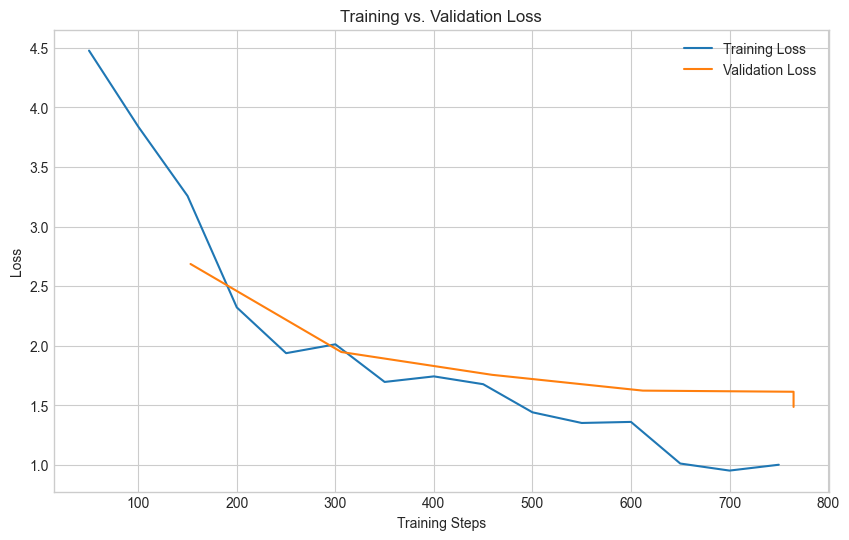

In [10]:
plot_loss_curves(trained_lora_model.state.log_history)

In [9]:
import torch
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

In [17]:
pip install --upgrade bitsandbytes

Python(88998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas transformers peft datasets scikit-learn torch bitsandbytes

In [6]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.8 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 61.1 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 86.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
